# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Training Pipeline Notebook</div></center></span>

I separated the machine learning training pipeline from the EDA for cleaner approach.

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Import Necessary Libraries</div></center></span>

In [1]:
# Exploration purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Model related
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
from sklearn import set_config
from joblib import dump
from joblib import load

# Data balancing
from collections import Counter
from imblearn.over_sampling import SMOTE

# Other
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Load Dataset</div></center></span>

In [2]:
dataset_dir = '../dataset/cleaned-fraud-payments.csv'
payment_fraud_df = pd.read_csv(dataset_dir)

In [3]:
payment_fraud_df

,step,type,amount,isFraud,isFlaggedFraud,diffOrig,diffDest
0,1,PAYMENT,9839.64,0,0,9839.64,0.00
1,1,PAYMENT,1864.28,0,0,1864.28,0.00
2,1,TRANSFER,181.00,1,0,181.00,0.00
3,1,CASH_OUT,181.00,1,0,181.00,21182.00
4,1,PAYMENT,11668.14,0,0,11668.14,0.00
...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,1,0,339682.13,-339682.13
6362616,743,TRANSFER,6311409.28,1,0,6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,1,0,6311409.28,-6311409.27
6362618,743,TRANSFER,850002.52,1,0,850002.52,0.00


# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Data Preprocessing</div></center></span>

## Train Test Split

In [4]:
X = payment_fraud_df.drop(columns='isFraud')
y = payment_fraud_df['isFraud']

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Check each sample of splitted data
print(f'Total # of sample in whole dataset: {len(X)}')
print('=========================================')
print(f'Total # of sample in train dataset: {len(X_train)}')
print('=========================================')
print(f'Total # of sample in test dataset: {len(X_test)}')


Total # of sample in whole dataset: 6362620
Total # of sample in train dataset: 4453834
Total # of sample in test dataset: 1908786


## One Hot Encoding
Because there is only five unique value in this column we can use one hot encoding to turn the categorical into numeric value, so the ML algorithm can process it.

In [7]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

### Scaling with Robust Scaler

From our exploration phase, we concluded that the dataset are heavily-imbued with outliers, that's why we use Robust Scaler to scale it.  RobustScaler is a preprocessing technique used to scale numeric features in a dataset. It scales the features to be centered around the median value and scales the data according to the interquartile range (IQR) rather than the mean and standard deviation, which makes it robust to outliers.

In [8]:
scaler = RobustScaler()

## Column Transformer

In [9]:
# Define numeric and categorical features
numerical_features = payment_fraud_df.select_dtypes(exclude=object).columns.tolist()
categorical_features = ['type']

In [10]:
# Remove label from feature
numerical_features.remove('isFraud')

In [11]:
# Define column transformer for pipeline use later
preprocessor = ColumnTransformer([
    ('encoder', encoder, categorical_features),
    ('scaler', scaler, numerical_features)
], remainder="passthrough")

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Model Building</div></center></span>

## Base Model Testing

Before building pipeline, model selection or hyperparameter tuning first we are gonna compare all of ML algorithm to select the best base for our model

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [4:29:14<00:00, 557.05s/it]   


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,0.89,0.89,1.00,101.68
DecisionTreeClassifier,1.00,0.89,0.89,1.00,57.05
BaggingClassifier,1.00,0.88,0.88,1.00,366.75
RandomForestClassifier,1.00,0.87,0.87,1.00,1235.37
ExtraTreesClassifier,1.00,0.85,0.85,1.00,312.81
KNeighborsClassifier,1.00,0.84,0.84,1.00,1221.42
ExtraTreeClassifier,1.00,0.84,0.84,1.00,6.41
PassiveAggressiveClassifier,1.00,0.82,0.82,1.00,8.65
GaussianNB,0.64,0.81,0.81,0.78,5.93


After testing our dataset to some base model we found out that our earlier hypothesis were true, that tree and bagging-based algorithm work great with heavily imbalanced data, and also there's xgboost as usual.  Next we can just use the top algorithm from above to do some hyperparameter tuning and made our models.  We are going to tune Decision Tree and XGBoost as two best models.


## Hyperparameter Tuning

We will use RandomizedSearchCV instead of GridSearch because the dataset size is huge (6 mil rows), and it will take too long for the grid search to search all the best parameter.

### Decision Tree

In [12]:
param_dt = {"criterion":["gini", "entropy"],
                 "splitter":["best", "random"],
                 "max_depth": [None, 3, 6, 9, 12],
                 "max_features":[None, 3, 5, 7],
                 "min_samples_leaf": [2, 3, 4],
                 "min_samples_split": [2, 3, 5, 7, 9, 12]}

In [15]:
dt_rscv = DecisionTreeClassifier(class_weight = "balanced", random_state=42)
dt_model = RandomizedSearchCV(estimator=dt_rscv,
                             param_distributions=param_dt,
                             n_iter=5,
                             scoring='precision',
                             n_jobs=-1,
                             cv=10,
                             random_state=42,
                             verbose=1)

### XGBoost

For the xgboost model we will just tune the hyperparams manually because even RSCV is taking so looooooooooooooong, like fr fr.

In [28]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, 
                        n_estimators=100, 
                        max_depth=3, 
                        min_child_weight=1, 
                        gamma=0.1, 
                        subsample=0.8, 
                        colsample_bytree=0.8, 
                        objective='binary:logistic', 
                        nthread=4, 
                        scale_pos_weight=1, 
                        seed=42,
                        random_state=42)

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Building Training Pipeline</div></center></span>

In [18]:
# Define function to train models
def train_model(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test, y_pred)))
    plot_roc_curve(classifier, X_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

    return classifier

def evaluate_model(classifier, X_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test, classifier.predict(X_test)))


## DT Pipeline

In [19]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model)
])

In [20]:
# Visualize pipeline
set_config(display='diagram')
dt_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type']),
                                                 ('scaler', RobustScaler(),
                                                  ['step', 'amount',
                                                   'isFlaggedFraud', 'diffOrig',
                                                   'diffDest'])])),
                ('classifier',
                 RandomizedSearchCV(cv=10,
                                    estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42),
                                    n_iter=5, n_jobs=-1,
                                    param_distributions={'criterion': ['gini',
                                                                       'entropy'],
                                                         'max_depth': [None, 3,
                                                                       6, 9,
                                                                       12],
                                                         'max_features': [None,
                                                                          3, 5,
                                                                          7],
                                                         'min_samples_leaf': [2,
                                                                              3,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               3,
                                                                               5,
                                                                               7,
                                                                               9,
                                                                               12],
                                                         'splitter': ['best',
                                                                      'random']},
                                    random_state=42, scoring='f1',
                                    verbose=1))])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for eac

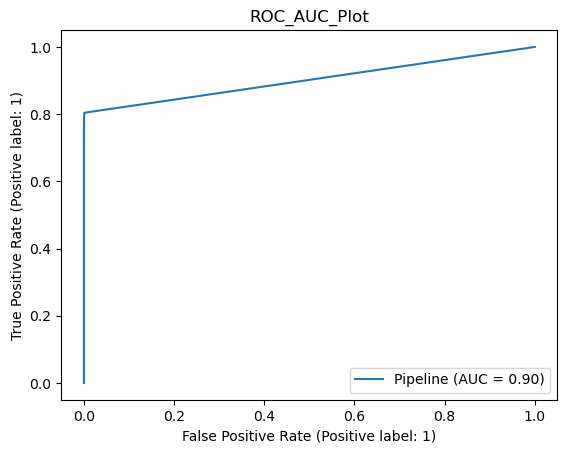

In [21]:
# Train model
dt_model = train_model(dt_pipeline, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.54      0.80      0.65      2435

    accuracy                           1.00   1908786
   macro avg       0.77      0.90      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



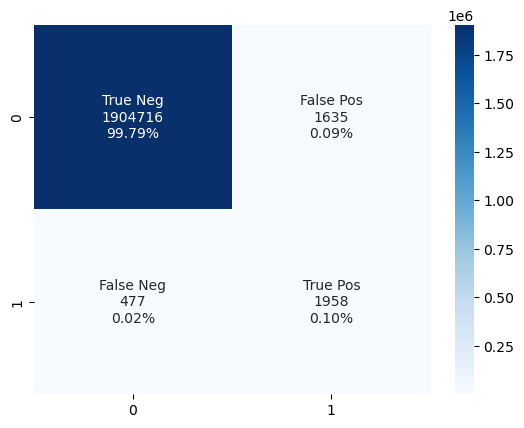

In [22]:
evaluate_model(dt_model, X_test, y_test)

## XGB Pipeline


In [33]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

In [34]:
# Visualize pipeline
set_config(display='diagram')
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type']),
                                                 ('scaler', RobustScaler(),
                                                  ['step', 'amount',
                                                   'isFlaggedFraud', 'diffOrig',
                                                   'diffDest'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, nthread=4,
                               num_parallel_tree=None, predictor=None, ...))])

Cross Validation Score :  99.50%
ROC_AUC Score :  83.74%


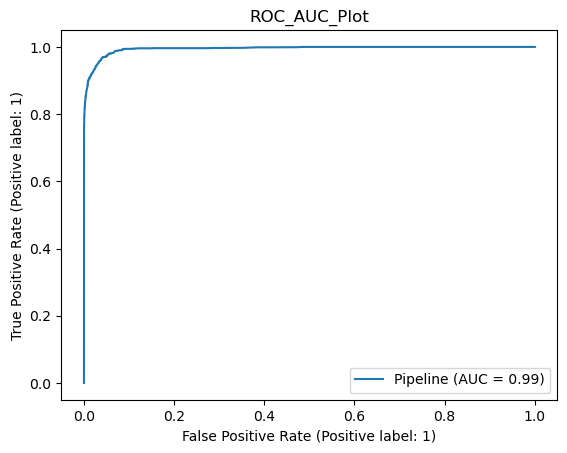

In [35]:
# Train model
xgb_model = train_model(xgb_pipeline, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.67      0.80      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.84      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



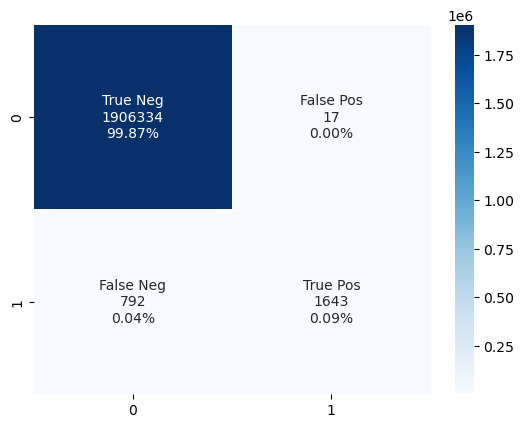

In [37]:
evaluate_model(xgb_model, X_test, y_test)

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Verdict</div></center></span>

For fraud transaction detection, both precision and recall are important, but the choice of which metric to prioritize depends on the specific business needs and goals.

Precision is the fraction of predicted fraud cases that are actually fraudulent, while recall is the fraction of actual fraud cases that are correctly identified by the model.

If the cost of false positives (i.e., identifying a transaction as fraudulent when it's actually legitimate) is high, then precision should be the primary focus. A high precision means that the model is identifying only the transactions that are most likely to be fraudulent, reducing the number of false positives and the associated costs.

On the other hand, if the cost of false negatives (i.e., failing to identify a fraudulent transaction) is high, then recall should be the primary focus. A high recall means that the model is identifying more of the fraudulent transactions, reducing the number of false negatives and the associated losses.

But for this project we will go with precision as the main metrics, so the XGBoost algorithm with 99% precision is the winner!

### Save Best Model

In [46]:
model = xgb_model
path_to_dir = '../model/'
filename = 'xgboost_model-01.joblib'

joblib.dump(model, path_to_dir+filename)

['../model/xgboost_model-01.joblib']

### Load Model

In [47]:
mdl = joblib.load(path_to_dir+filename)

In [48]:
mdl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type']),
                                                 ('scaler', RobustScaler(),
                                                  ['step', 'amount',
                                                   'isFlaggedFraud', 'diffOrig',
                                                   'diffDest'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, nthread=4,
                               num_parallel_tree=None, predictor=None, ...))])

# <span><center><div style="font-family: Trebuchet MS; background-color: #1e81b0; color: #eeeee4; padding: 12px; line-height: 1;">Conclusion</div></center></span>

- This project is really challenging because the dataset's label have heavily imbalanced ratio of fraud : non-fraud is 1:99, but we are able to build a model that could suffice our objective (for now) with high precision (99%)
- On fraud detection system both precision and recall are important, but on this project we will focus on precision because we want our model to actually predict transactions that most likely to be fraudulent and the XGBoost model seems to be the best for it, since it have 99% precision and 80% f1-score.
- Need more research about whether there is actually a way to handle this kind of heavily imbalanced data